In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Lets upload the data set from google drive. and run some checks to make sure the data is how i want them: Just as the previous ones

In [6]:
import json

In [7]:
import os, shutil, pathlib

In [8]:
files = os.listdir("/content/drive/MyDrive/train")
print(len(files))

8005


In [9]:
print(files[:20])
print(files[-20:])

['dog.3006.jpg', 'dog.3007.jpg', 'dog.3008.jpg', 'dog.3009.jpg', 'dog.3010.jpg', 'dog.3011.jpg', 'dog.3012.jpg', 'dog.3013.jpg', 'dog.3014.jpg', 'dog.3015.jpg', 'dog.3016.jpg', 'dog.3017.jpg', 'dog.3018.jpg', 'dog.3019.jpg', 'dog.3020.jpg', 'dog.3021.jpg', 'dog.3022.jpg', 'dog.3023.jpg', 'dog.3024.jpg', 'dog.3025.jpg']
['cat.991.jpg', 'cat.992.jpg', 'cat.993.jpg', 'cat.994.jpg', 'cat.995.jpg', 'cat.996.jpg', 'cat.997.jpg', 'cat.998.jpg', 'cat.999.jpg', 'cat.1000.jpg', 'cat.1001.jpg', 'cat.1002.jpg', 'cat.1003.jpg', 'cat.1004.jpg', 'cat.1005.jpg', 'cat.1.jpg', 'cat.2.jpg', 'cat.3.jpg', 'cat.4.jpg', 'cat.5.jpg']


copying images to training, validation, and test directories:

In [10]:
original_dir = pathlib.Path("/content/drive/MyDrive/train")  #path to the directory where the original data was uncompressed.
new_base_dir = pathlib.Path("/content/drive/MyDrive/cats_vs_dogs_small") # directory where we will store our smaller dataset.

In [ ]:

def make_subset(subset_name, start_index, end_index):
  for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir, exist_ok=True)

    all_files = sorted([f for f in os.listdir(original_dir) if f.startswith(category)])
    selected_files = all_files[start_index:end_index]

    for fname in selected_files:
      dst = dir/fname
      if dst.exists():
        print(f"{dst} already exists")
        continue
      shutil.copyfile(src=original_dir / fname,
                      dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

/content/drive/MyDrive/cats_vs_dogs_small/train/cat/cat.1.jpg already exists
/content/drive/MyDrive/cats_vs_dogs_small/train/cat/cat.10.jpg already exists
/content/drive/MyDrive/cats_vs_dogs_small/train/cat/cat.100.jpg already exists
/content/drive/MyDrive/cats_vs_dogs_small/train/cat/cat.1000.jpg already exists
/content/drive/MyDrive/cats_vs_dogs_small/train/cat/cat.1001.jpg already exists
/content/drive/MyDrive/cats_vs_dogs_small/train/cat/cat.1002.jpg already exists
/content/drive/MyDrive/cats_vs_dogs_small/train/cat/cat.1003.jpg already exists
/content/drive/MyDrive/cats_vs_dogs_small/train/cat/cat.1004.jpg already exists
/content/drive/MyDrive/cats_vs_dogs_small/train/cat/cat.1005.jpg already exists
/content/drive/MyDrive/cats_vs_dogs_small/train/cat/cat.1006.jpg already exists
/content/drive/MyDrive/cats_vs_dogs_small/train/cat/cat.1007.jpg already exists
/content/drive/MyDrive/cats_vs_dogs_small/train/cat/cat.1008.jpg already exists
/content/drive/MyDrive/cats_vs_dogs_small/trai

In [11]:
from tensorflow.keras.utils import image_dataset_from_directory

In [12]:

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


### Feature extraction with a pretrained model

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

Lets instantitate the VGG16 Convolutional Base

In [14]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


read the book for the explanation of the three arguments passed to the constructor.

lets view the detail architecture of the VGG16 convolutional base:

In [15]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

As you can see, the final feature map has shape(5, 5, 512). That is the feature map on top of which  we will stick a densely connected classifier.

At this point, we have two ways to proceed: Fast feature extraction without data augmentation and the feature extraction with data augmentation: which is more expensive.
lets start with the first one

## fast feature extraction without data augmentation

Lets iterate over our dataset to extract VGG16 features.

In [19]:
import numpy as np

In [ ]:

def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    features = conv_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [17]:
# lets check the shape of our features
#train_features.shape, val_features.shape, test_features.shape

It will be good to just save this features, so as to avoid feature extraction everytime i come back to run this again.

In [ ]:
# np.save("/content/drive/MyDrive/train_features.npy", train_features)
# np.save("/content/drive/MyDrive/train_labels.npy", train_labels)

# np.save("/content/drive/MyDrive/val_features.npy", val_features)
# np.save("/content/drive/MyDrive/val_labels.npy", val_labels)

# np.save("/content/drive/MyDrive/test_features.npy", test_features)
# np.save("/content/drive/MyDrive/test_labels.npy", test_labels)

Now i can reload them back and continue.

In [20]:
train_features = np.load("/content/drive/MyDrive/train_features.npy")
train_labels = np.load("/content/drive/MyDrive/train_labels.npy")

val_features = np.load("/content/drive/MyDrive/val_features.npy")
val_labels = np.load("/content/drive/MyDrive/val_labels.npy")

test_features = np.load("/content/drive/MyDrive/test_features.npy")
test_labels = np.load("/content/drive/MyDrive/test_labels.npy")

We can now define our densely connected classifier. take note of the use of dropout and regularization. Then we train this classifier on the data and labels we recorder above.

In [21]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [23]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath = "/content/drive/MyDrive/feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss"
)]

In [24]:
history = model.fit(train_features, train_labels,
                    epochs=20, validation_data=(val_features, val_labels),
                    callbacks=callbacks)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8665 - loss: 18.7883 - val_accuracy: 0.9650 - val_loss: 5.4468
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9789 - loss: 3.6455 - val_accuracy: 0.9530 - val_loss: 10.0620
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9755 - loss: 3.7868 - val_accuracy: 0.9710 - val_loss: 4.2190
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9942 - loss: 0.7470 - val_accuracy: 0.9670 - val_loss: 4.9503
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9965 - loss: 0.3070 - val_accuracy: 0.9660 - val_loss: 5.7154
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9937 - loss: 0.6963 - val_accuracy: 0.9720 - val_loss: 5.6901
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9987 - loss: 0.0893 - val_accuracy: 0.9690 - val_loss: 6.2870
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9958 - loss: 0.2742 - val_accuracy: 0.9630 - val_lo

In [25]:
model = keras.models.load_model("/content/drive/MyDrive/feature_extraction.keras")

Now lets plot and look at the loss and accuracy curve.

In [26]:
import matplotlib.pyplot as plt

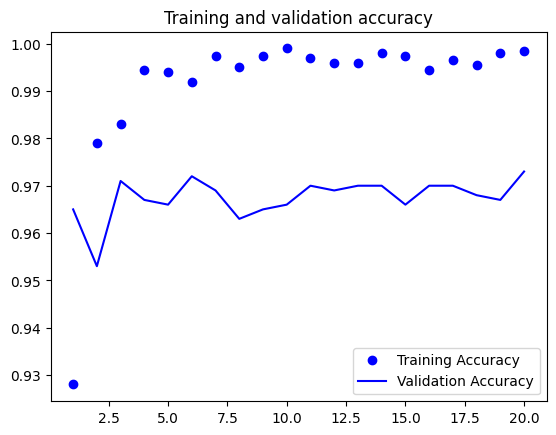

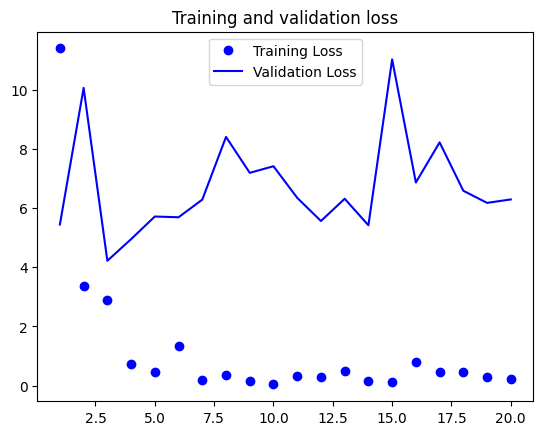

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()